## &#x1F310; &nbsp; Code Library, Style, and Links
The previous notebooks:

&#x1F310; &nbsp; [PASSNYC. Data Exploration](https://www.kaggle.com/olgabelitskaya/passnyc-data-exploration)

&#x1F310; &nbsp; [PASSNYC. Numeric and Categorical Variables](https://www.kaggle.com/olgabelitskaya/passnyc-numeric-and-categorical-variables)

&#x1F310; &nbsp; [PASSNYC. Comparing All Districts with 5th District](passnyc-comparing-all-districts-with-5th-district)

In [98]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #aaa;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}              
</style>

In [99]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from descartes import PolygonPatch

from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

In [100]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

## &#x1F310; &nbsp; Load and Preprocess the Data

In [101]:
school_explorer = pd.read_csv('2016 School Explorer.csv')
d5_shsat = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
school_explorer.shape, d5_shsat.shape

((1272, 161), (140, 7))

In [102]:
# Fillna or replace values
numeric_list = list(school_explorer\
.columns[[7,8]+list(range(16,27))+[28,30,32,34,36]+list(range(42,161))])
target_list = ['Average ELA Proficiency','Average Math Proficiency']
len(numeric_list)

school_explorer = school_explorer.drop(['Adjusted Grade',
                                        'New?',
                                        'Other Location Code in LCGMS'], 
                                       axis=1)
school_explorer.loc[[427,1023,712,908],'School Name'] = \
['P.S. 212 D12','P.S. 212 D30','P.S. 253 D21','P.S. 253 D27']

percent_list = ['Percent ELL','Percent Asian','Percent Black',
                'Percent Hispanic','Percent Black / Hispanic',
                'Percent White','Student Attendance Rate',
                'Percent of Students Chronically Absent',
                'Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %',
                'Strong Family-Community Ties %','Trust %']

for el in percent_list:
    school_explorer[el] = school_explorer[el].astype('str')
    school_explorer[el] = school_explorer[el].str.replace("%", "")
    school_explorer[el] = school_explorer[el].str.replace("nan", "0")
    school_explorer[el] = school_explorer[el].astype(float)
    school_explorer[el].replace(0, np.NaN, inplace=True)
    school_explorer[el] = school_explorer[el].interpolate()
    
school_explorer['Economic Need Index'] = \
school_explorer['Economic Need Index'].interpolate()
school_explorer['Average ELA Proficiency'] = \
school_explorer['Average ELA Proficiency'].interpolate()
school_explorer['Average Math Proficiency'] = \
school_explorer['Average Math Proficiency'].interpolate()

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype('str') 
for s in [",","$"," "]:
    school_explorer['School Income Estimate'] = \
    school_explorer['School Income Estimate'].str.replace(s, "")
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].str.replace("nan", "0")

school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].astype(float)
school_explorer['School Income Estimate'].replace(0, np.NaN, inplace=True)
school_explorer['School Income Estimate'] = \
school_explorer['School Income Estimate'].interpolate()

rating_list = ['Rigorous Instruction Rating','Collaborative Teachers Rating',
               'Supportive Environment Rating','Effective School Leadership Rating',
               'Strong Family-Community Ties Rating','Strong Family-Community Ties Rating',
               'Trust Rating','Student Achievement Rating']

for el in rating_list:
    moda_value = school_explorer[el].value_counts().idxmax()
    school_explorer[el] = school_explorer[el].fillna(moda_value) 
    
category_list1 = ['District','Community School?','City','Grades']
                  
category_list2 = ['Rigorous Instruction Rating',
                  'Collaborative Teachers Rating',
                  'Supportive Environment Rating',
                  'Effective School Leadership Rating',
                  'Strong Family-Community Ties Rating',
                  'Trust Rating','Student Achievement Rating']

for feature in category_list1:
    feature_cat = pd.factorize(school_explorer[feature])
    school_explorer[feature] = feature_cat[0]
    
for feature in category_list2:
    feature_pairs = dict(zip(['Not Meeting Target', 'Meeting Target', 
                              'Approaching Target', 'Exceeding Target'],
                             ['0','2','1','3']))
    school_explorer[feature].replace(feature_pairs,inplace=True)
    school_explorer[feature] = school_explorer[feature].astype(int)
    
category_list = list(category_list1+category_list2)
    
print('NaN count = ', sum(school_explorer.isna().sum()))    

NaN count =  0


In [103]:
# Merge two datasets
d5_shsat_2016 = d5_shsat[['DBN','Number of students who registered for the SHSAT',
                          'Number of students who took the SHSAT']][d5_shsat['Year of SHST']==2016]\
.groupby(['DBN'],as_index=False).agg(np.sum)

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Number of students who took the SHSAT']\
/d5_shsat_2016['Number of students who registered for the SHSAT']

d5_shsat_2016['Took SHSAT %'] = d5_shsat_2016['Took SHSAT %'].fillna(0).apply(lambda x: round(x,3))
d5_shsat_2016.rename(columns={'DBN':'Location Code'}, inplace=True)

d5_shsat_2016 = pd.merge(school_explorer[['Location Code']+numeric_list+target_list],
                         d5_shsat_2016, 
                         on='Location Code')
d5_shsat_2016.shape

(21, 143)

## &#x1F310; &nbsp; Split the Data for Regressor Training

#### The first set of features

In [104]:
# data = school_explorer, features = numeric veriables, targets = Average Math Proficiency
features = school_explorer[numeric_list].values
targets = school_explorer['Average Math Proficiency'].values

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((1017, 137), (255, 137), (1017,), (255,))

In [105]:
# data = school_explorer, features = numeric veriables, targets = Average ELA Proficiency
features = school_explorer[numeric_list].values
targets = school_explorer['Average ELA Proficiency'].values

X_train2, X_test2, y_train2, y_test2 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((1017, 137), (255, 137), (1017,), (255,))

#### The second set of features

In [106]:
# data = school_explorer, 
features_list = percent_list+category_list+['School Income Estimate','Economic Need Index'] 
# targets = Average Math Proficiency
features = school_explorer[features_list].values
targets = school_explorer['Average Math Proficiency'].values

X_train3, X_test3, y_train3, y_test3 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((1017, 27), (255, 27), (1017,), (255,))

In [107]:
# data = school_explorer, 
features_list = percent_list+category_list+['School Income Estimate','Economic Need Index'] 
# targets = Average ELA Proficiency
features = school_explorer[features_list].values
targets = school_explorer['Average ELA Proficiency'].values

X_train4, X_test4, y_train4, y_test4 = \
train_test_split(features, targets, test_size=0.2, random_state=1)
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((1017, 27), (255, 27), (1017,), (255,))

## &#x1F310; &nbsp; Fit the Regressors

#### The first set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition and test results of each grade.

In [230]:
y_train_gbr1, y_test_gbr1 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=137), 
           X_train1, X_test1, y_train1)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_gbr1, y_test_gbr1)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9801848736946983
EV score. Test:  0.8912013910815904
---------
R2 score. Train:  0.9801848736946983
R2 score. Test:  0.8911547337031857
---------
MSE score. Train:  0.004318660245727968
MSE score. Test:  0.023237198533535324
---------
MAE score. Train:  0.05088943632983996
MAE score. Test:  0.11522757087128746
---------
MdAE score. Train:  0.040694046585668886
MdAE score. Test:  0.09003741728561865


In [231]:
y_train_rfr1, y_test_rfr1 = \
regression(RandomForestRegressor(n_estimators=137), 
           X_train1, X_test1, y_train1)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train1, y_test1, y_train_rfr1, y_test_rfr1)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9771607704205545
EV score. Test:  0.8829294106609749
---------
R2 score. Train:  0.9771427988256437
R2 score. Test:  0.8829288726294943
---------
MSE score. Train:  0.004981673319634003
MSE score. Test:  0.024993324209753566
---------
MAE score. Train:  0.05018947060554506
MAE score. Test:  0.12078064023663
---------
MdAE score. Train:  0.037591240875909815
MdAE score. Test:  0.09200729927007334


In [232]:
y_train_gbr2, y_test_gbr2 = \
regression(GradientBoostingRegressor(max_depth=5, n_estimators=274), 
           X_train2, X_test2, y_train2)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train2, y_test2, y_train_gbr2, y_test_gbr2)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9990047193898323
EV score. Test:  0.8753076183497122
---------
R2 score. Train:  0.9990047193898323
R2 score. Test:  0.8752065810325145
---------
MSE score. Train:  0.0001251506286896274
MSE score. Test:  0.017923118684878468
---------
MAE score. Train:  0.008396192726174782
MAE score. Test:  0.09860017523091244
---------
MdAE score. Train:  0.006189548213040297
MdAE score. Test:  0.07222889771149932


In [233]:
y_train_rfr2, y_test_rfr2 = \
regression(RandomForestRegressor(n_estimators=274), 
           X_train2, X_test2, y_train2)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train1, y_test2, y_train_rfr2, y_test_rfr2)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.8207116984429181
EV score. Test:  0.8450234204604234
---------
R2 score. Train:  0.7339020214229807
R2 score. Test:  0.8450115536961573
---------
MSE score. Train:  0.05799542954423025
MSE score. Test:  0.022259798159808813
---------
MAE score. Train:  0.18650888364949145
MAE score. Test:  0.10752115118553503
---------
MdAE score. Train:  0.14870437956203952
MdAE score. Test:  0.07478558394160695


#### The second set of features
The predictions are based on the data about the financial situation, social environment, ethnic composition and geoposition.

In [234]:
y_train_gbr3, y_test_gbr3 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Gradient Boosting Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_gbr3, y_test_gbr3)

_______________________________________
Gradient Boosting Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.950148691725299
EV score. Test:  0.859072153215082
---------
R2 score. Train:  0.950148691725299
R2 score. Test:  0.8587597689186824
---------
MSE score. Train:  0.010864975571004975
MSE score. Test:  0.030153146776352186
---------
MAE score. Train:  0.08038728735945015
MAE score. Test:  0.1307862762272266
---------
MdAE score. Train:  0.06329352049169534
MdAE score. Test:  0.09617163621473201


In [235]:
y_train_rfr3, y_test_rfr3 = \
regression(RandomForestRegressor(n_estimators=81), 
           X_train3, X_test3, y_train3)

scores('Random Forest Regressor \nAverage Math Proficiency', 
       y_train3, y_test3, y_train_rfr3, y_test_rfr3)

_______________________________________
Random Forest Regressor 
Average Math Proficiency
_______________________________________
EV score. Train:  0.9714845874922369
EV score. Test:  0.8413993424283284
---------
R2 score. Train:  0.9714648660101809
R2 score. Test:  0.8413609964589
---------
MSE score. Train:  0.006219165443087838
MSE score. Test:  0.03386758235672253
---------
MAE score. Train:  0.055157719994658745
MAE score. Test:  0.1400960421205519
---------
MdAE score. Train:  0.03932098765432279
MdAE score. Test:  0.1141666666666672


In [236]:
y_train_gbr4, y_test_gbr4 = \
regression(GradientBoostingRegressor(max_depth=4, n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Gradient Boosting Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_gbr4, y_test_gbr4)

_______________________________________
Gradient Boosting Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.959742508489626
EV score. Test:  0.8527811922085368
---------
R2 score. Train:  0.959742508489626
R2 score. Test:  0.8526818520408349
---------
MSE score. Train:  0.005062140586805272
MSE score. Test:  0.02115817221897373
---------
MAE score. Train:  0.055913030278784755
MAE score. Test:  0.10476286013834882
---------
MdAE score. Train:  0.04733115290358869
MdAE score. Test:  0.08252873069568611


In [243]:
y_train_rfr4, y_test_rfr4 = \
regression(RandomForestRegressor(n_estimators=108), 
           X_train4, X_test4, y_train4)

scores('Random Forest Regressor \nAverage ELA Proficiency', 
       y_train4, y_test4, y_train_rfr4, y_test_rfr4)

_______________________________________
Random Forest Regressor 
Average ELA Proficiency
_______________________________________
EV score. Train:  0.9739841301069891
EV score. Test:  0.8306101198720397
---------
R2 score. Train:  0.9739834012080106
R2 score. Test:  0.8305221106892483
---------
MSE score. Train:  0.0032714328621697773
MSE score. Test:  0.02434080538630588
---------
MAE score. Train:  0.04098608683248972
MAE score. Test:  0.10977115105301392
---------
MdAE score. Train:  0.028888888888884967
MdAE score. Test:  0.07499999999999973


## &#x1F310; &nbsp; Display Predictions

#### The first set of features

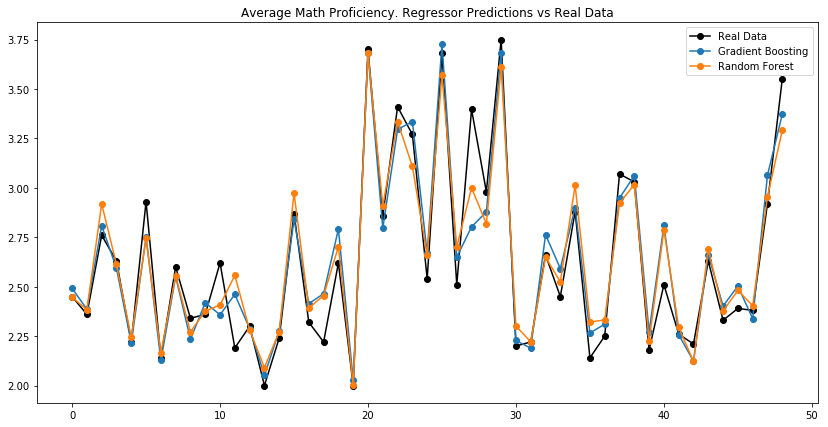

In [238]:
plt.figure(figsize = (14, 7))

plt.plot(y_test1[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr1[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr1[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

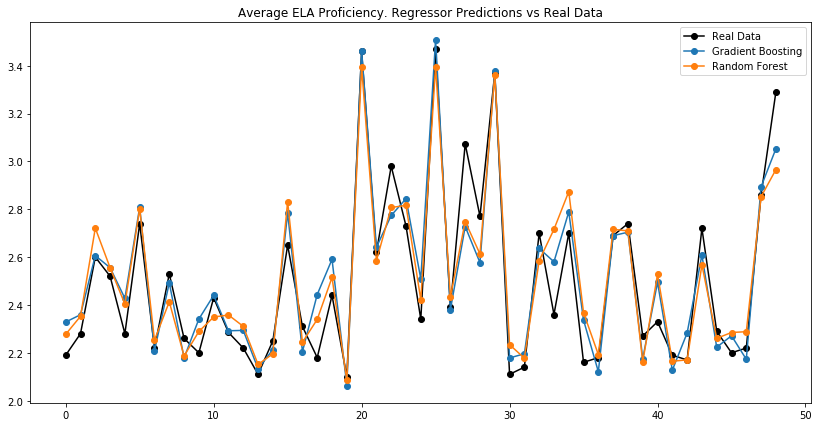

In [239]:
plt.figure(figsize = (14, 7))

plt.plot(y_test2[1:50], '-o', color='black', label='Real Data')
plt.plot(y_test_gbr2[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr2[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

The numerical variables in the presented database about the financial situation, social environment, ethnic composition and test results of each grade  make it possible to predict the indicators of learning outcomes `Average Math Proficiency`, `Average ELA Proficiency` quite well (0.84-0.89 is a really high level for R2).

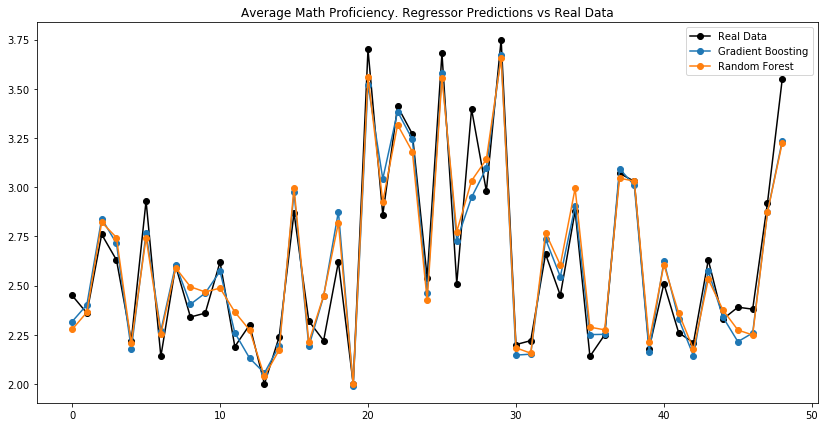

In [240]:
plt.figure(figsize = (14, 7))

plt.plot(y_test3[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr3[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr3[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average Math Proficiency. Regressor Predictions vs Real Data");

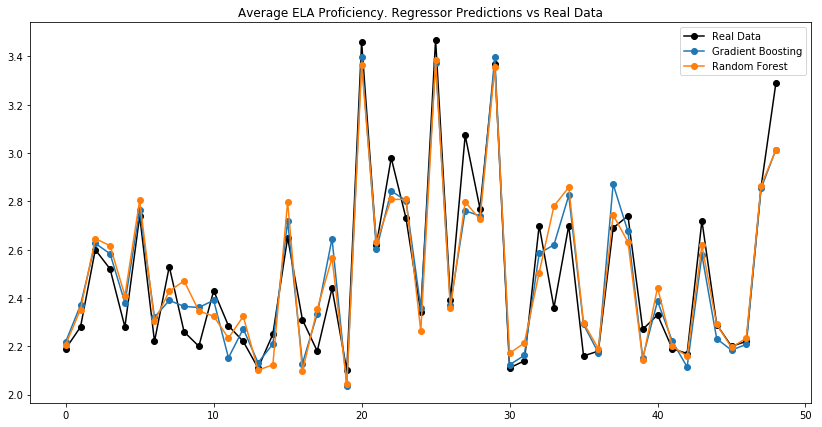

In [241]:
plt.figure(figsize = (14, 7))

plt.plot(y_test4[1:50], '-o', color = 'black', label='Real Data')
plt.plot(y_test_gbr4[1:50], '-o', label='Gradient Boosting')
plt.plot(y_test_rfr4[1:50], '-o', label='Random Forest')

plt.legend()
plt.title("Average ELA Proficiency. Regressor Predictions vs Real Data");

The numerical variables in the presented database about the financial situation, social environment, ethnic composition and geoposition make predictions the indicators of learning outcomes `Average Math Proficiency`, `Average ELA Proficiency`  a little bit worse  (0.83-0.86 for R2).

## &#x1F310; &nbsp; Features' Importance

#### The first set of features

In [163]:
df_importance1 = pd.DataFrame(columns=range(137))

df_importance1.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=137)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[1] = RandomForestRegressor(n_estimators=137)\
.fit(X_train1, y_train1).feature_importances_
df_importance1.loc[2] = GradientBoostingRegressor(max_depth=5, n_estimators=274)\
.fit(X_train2, y_train2).feature_importances_
df_importance1.loc[3]= RandomForestRegressor(n_estimators=274)\
.fit(X_train2, y_train2).feature_importances_

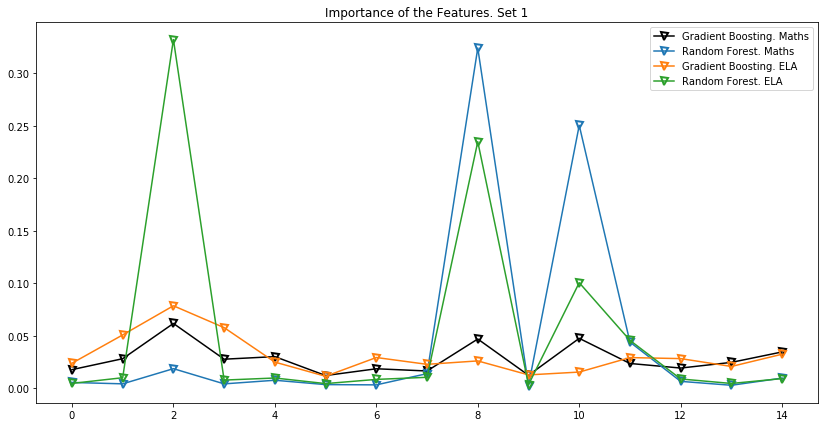

In [189]:
plt.figure(figsize=(14,7))
n=15

plt.plot(df_importance1.loc[0][:n], '-v', color = 'black', label='Gradient Boosting. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[1][:n], '-v', label='Random Forest. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[2][:n], '-v', label='Gradient Boosting. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance1.loc[3][:n], '-v', label='Random Forest. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 1");

In [210]:
index_gbr_math1 = list(df_importance1.loc[0,].sort_values(ascending=False)[:20].index)
index_rfr_math1 = list(df_importance1.loc[1,].sort_values(ascending=False)[:20].index)
index_gbr_ela1 = list(df_importance1.loc[2,].sort_values(ascending=False)[:20].index)
index_rfr_ela1 = list(df_importance1.loc[3,].sort_values(ascending=False)[:20].index)
features1 = school_explorer[numeric_list]

The most influential indicators for the variable `Average Math Proficiency`:

In [211]:
for el in list(features1.iloc[:,index_gbr_math1].columns):
    if el in list(features1.iloc[:,index_rfr_math1].columns):
        print(el)

Economic Need Index
Student Attendance Rate
Percent Black / Hispanic
Supportive Environment %
Percent ELL
Grade 5 Math 4s - All Students
Percent of Students Chronically Absent
Grade 3 Math 4s - All Students
Grade 3 Math - All Students tested
Rigorous Instruction %
Strong Family-Community Ties %
Grade 6 Math 4s - All Students
Effective School Leadership %


The most influential indicators for the variable `Average ELA Proficiency`:

In [213]:
for el in list(features1.iloc[:,index_gbr_ela1].columns):
    if el in list(features1.iloc[:,index_rfr_ela1].columns):
        print(el)

Economic Need Index
School Income Estimate
Longitude
Supportive Environment %
Percent Black
Percent of Students Chronically Absent
Rigorous Instruction %
Strong Family-Community Ties %
Percent Black / Hispanic
Percent ELL
Percent Hispanic
Grade 3 Math 4s - All Students
Grade 5 ELA 4s - All Students
Student Attendance Rate


#### The second set of features

In [206]:
df_importance2 = pd.DataFrame(columns=range(27))

df_importance2.loc[0] = GradientBoostingRegressor(max_depth=4, n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[1] = RandomForestRegressor(n_estimators=81)\
.fit(X_train3, y_train3).feature_importances_
df_importance2.loc[2] = GradientBoostingRegressor(max_depth=4, n_estimators=108)\
.fit(X_train4, y_train4).feature_importances_
df_importance2.loc[3]= RandomForestRegressor(n_estimators=54)\
.fit(X_train4, y_train4).feature_importances_

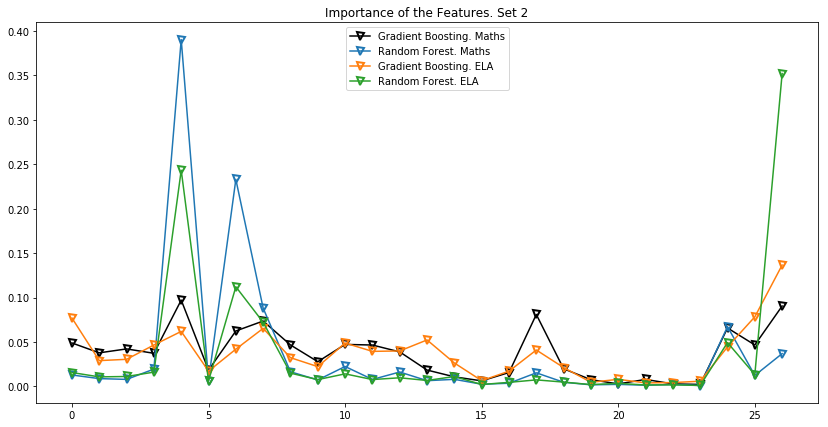

In [209]:
plt.figure(figsize=(14,7))
n=27

plt.plot(df_importance2.loc[0][:n], '-v', color = 'black', label='Gradient Boosting. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[1][:n], '-v', label='Random Forest. Maths',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[2][:n], '-v', label='Gradient Boosting. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)
plt.plot(df_importance2.loc[3][:n], '-v', label='Random Forest. ELA',
        markersize=7, markerfacecolor="None", markeredgewidth=2)

plt.legend()
plt.title("Importance of the Features. Set 2");

In [225]:
index_gbr_math2 = list(df_importance2.loc[0,].sort_values(ascending=False)[:15].index)
index_rfr_math2 = list(df_importance2.loc[1,].sort_values(ascending=False)[:15].index)
index_gbr_ela2 = list(df_importance2.loc[2,].sort_values(ascending=False)[:15].index)
index_rfr_ela2 = list(df_importance2.loc[3,].sort_values(ascending=False)[:15].index)
features2 = school_explorer[features_list]

The most influential indicators for the variable `Average Math Proficiency`:

In [226]:
for el in list(features2.iloc[:,index_gbr_math2].columns):
    if el in list(features2.iloc[:,index_rfr_math2].columns):
        print(el)

Percent Black / Hispanic
Economic Need Index
Grades
Percent of Students Chronically Absent
Student Achievement Rating
Student Attendance Rate
Percent ELL
Supportive Environment %
Rigorous Instruction %
School Income Estimate
Percent Black
Strong Family-Community Ties %
Percent Asian
Percent Hispanic


The most influential indicators for the variable `Average ELA Proficiency`:

In [228]:
for el in list(features2.iloc[:,index_gbr_ela2].columns):
    if el in list(features2.iloc[:,index_rfr_ela2].columns):
        print(el)

Economic Need Index
School Income Estimate
Percent ELL
Percent of Students Chronically Absent
Percent Black / Hispanic
Supportive Environment %
Percent Hispanic
Student Achievement Rating
Student Attendance Rate
Strong Family-Community Ties %
Effective School Leadership %
Rigorous Instruction %
Percent Black


In general, we can make a list of the most influential indicators for the educational results.

- Financial: `Economic Need Index`
- Social: `Supportive Environment`
- Organizational: `Student Attendance Rate`
- Linguistical: `Percent ELL`
- Ethnical: `Percent Black / Hispanic`